# Assignment 2: Boston Housing Price Prediction

Pada notebook ini, kita akan membangun sebuah machine learning model dengan Linear Regression menggunakan `sklearn` yang dapat memprediksi harga rumah di kota Boston. Dataset `boston` yang digunakan diperoleh dari [Kaggle](https://www.kaggle.com/vikrishnan/boston-house-prices).

# Import Libraries

Mari kita memanggil library yang akan digunakan pada notebook ini.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import display, Math

plt.style.use('seaborn')

# Data Loading

Load data berupa `csv` file dari folder `datasets`.

In [2]:
boston = pd.read_csv("../datasets/boston_data/boston_housing.csv")
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
print(f"Rows: {boston.shape[0]}")
print(f"Columns: {boston.shape[1]}")

Rows: 506
Columns: 14


Setiap baris pada data menggambarkan kota atau pinggiran kota Boston. Ada 506 baris dan 13 atribut (fitur) dengan 1 kolom target, yaitu harga rumah. Berikut adalah deskripsi data masing-masing atribut:

1. `crim` - tingkat kriminalitas per kapita
2. `zn` - proporsi tanah tempat tinggal yang dikategorikan untuk bidang lebih dari 25.000 kaki persegi
3. `indus` - proporsi hektar dari bisnis yang non-retail
4. `chas` - apakah saluran berbatasan dengan sungai Charles River? (1 = ya, 0 = tidak)
5. `nox` - konsentrasi nitrogen oksida (parts per 10 million)
6. `rm` - jumlah rata-rata kamar per hunian
7. `age` - proporsi unit yang ditempati pemilik yang dibangun sebelum tahun 1940
8. `dis` - rata-rata terbobot jarak ke lima pusat kerja Boston
9. `rad` - indeks aksesibilitas ke jalan raya radial
10. `tax` - nilai penuh tarif pajak properti (dalam puluhan ribu dollar)
11. `ptratio` - rasio murid dengan guru
12. `black` - $1000(Bk - 0.63)^2$ dengan $Bk$ adalah proporsi orang dengan kulit hitam
13. `lstat` - persentasi penduduk dengan status yang lebih rendah
14. `medv` - nilai median dari rumah yang ditempati pemilik (dalam ribu dolar)

# Data Preprocessing

Sebelum melangkah ke tahap modeling, ada baiknya kita melakukan pembersihan data untuk memastikan bahwa data sudah siap.

## Check Missing Values

Cek kelengkapan nilai pada data. Ternyata data yang kita miliki sudah lengkap.

In [4]:
boston.isnull().any()

crim       False
zn         False
indus      False
chas       False
nox        False
rm         False
age        False
dis        False
rad        False
tax        False
ptratio    False
b          False
lstat      False
medv       False
dtype: bool

## Data Types

Menyesuaikan tipe data

In [5]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
b          float64
lstat      float64
medv       float64
dtype: object

Kolom `chas` adalah sebuah data kategori dengan nilai 0 (No) dan 1 (Yes).

In [6]:
boston['chas'].unique()

array([0, 1], dtype=int64)

In [7]:
boston['chas'] = boston['chas'].astype('category')

Berikut tipe data setelah diubah:

In [8]:
boston.dtypes

crim        float64
zn          float64
indus       float64
chas       category
nox         float64
rm          float64
age         float64
dis         float64
rad           int64
tax           int64
ptratio     float64
b           float64
lstat       float64
medv        float64
dtype: object

# Exploratory Data Analysis

Pertama, kita lihat distribusi target variable `medv` menggunakan boxplot. Ternyata, terdapat cukup banyak outlier pada `medv`:

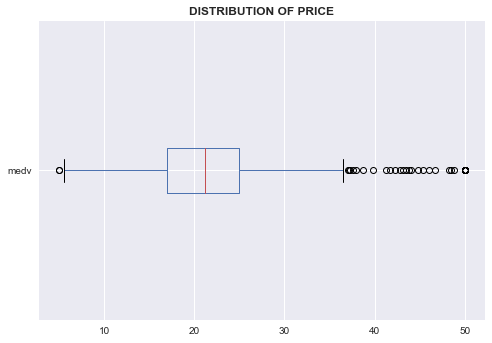

In [9]:
boston['medv'].plot.box(vert=False)
plt.title("DISTRIBUTION OF PRICE", fontweight='bold')
plt.show()

Kemudian kita tinjau persebaran `medv` berdasarkan `chas` (kolom yang kategorik). Ditemukan perbedaan persebaran antara `chas=0` dengan `chas=1` mengindikasikan bahwa `chas` menjadi calon prediktor yang baik untuk `medv`.

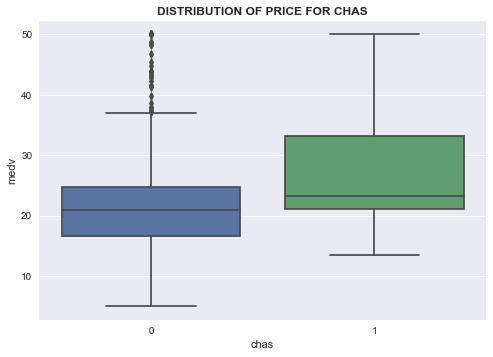

In [10]:
sns.boxplot(data=boston, x='chas', y='medv')
plt.title("DISTRIBUTION OF PRICE FOR CHAS", fontweight='bold')
plt.show()

Tinjau korelasi atau hubungan linear antar variable dalam `boston` menggunakan heatmap. Koefisien korelasi berkisar dari -1 sampai 1. Semakin mendekati 1 maka kedua variable memiliki korelasi positif yang kuat. Semakin mendekati -1 maka kedua variable memiliki korelasi negatif yang kuat. Ketika mendekati 0 maka tidak ada korelasi.

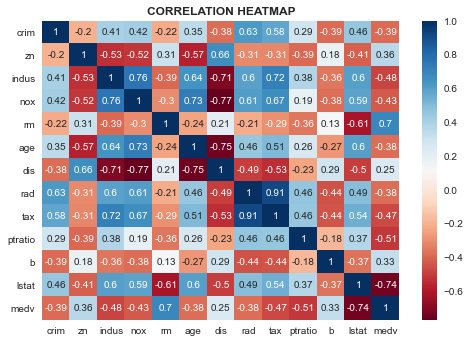

In [11]:
boston_corr = boston.corr()
sns.heatmap(boston_corr, annot=True, cmap='RdBu')
plt.title("CORRELATION HEATMAP", fontweight='bold')
plt.show()

Untuk membuat model regresi linear yang baik:
1. Pilih feature yang memiliki korelasi yang kuat dengan target variablenya:
    - `lstat` dengan `medv`: -0.737663
    - `rm` dengan `medv`: 0.695360

In [12]:
upper = boston_corr.where(np.triu(np.ones(boston_corr.shape), k=1).astype(np.bool))
pairwise_corr = upper.stack().reset_index()
pairwise_corr.columns = ['feature_1', 'feature_2', 'correlation']
pairwise_corr['abs_correlation'] = pairwise_corr['correlation'].abs()
pairwise_corr[pairwise_corr['feature_2'] == 'medv'].sort_values('abs_correlation', ascending = False)

,feature_1,feature_2,correlation,abs_correlation
77,lstat,medv,-0.737663,0.737663
49,rm,medv,0.695360,0.695360
74,ptratio,medv,-0.507787,0.507787
32,indus,medv,-0.483725,0.483725
71,tax,medv,-0.468536,0.468536
41,nox,medv,-0.427321,0.427321
11,crim,medv,-0.388305,0.388305
67,rad,medv,-0.381626,0.381626
56,age,medv,-0.376955,0.376955
22,zn,medv,0.360445,0.360445


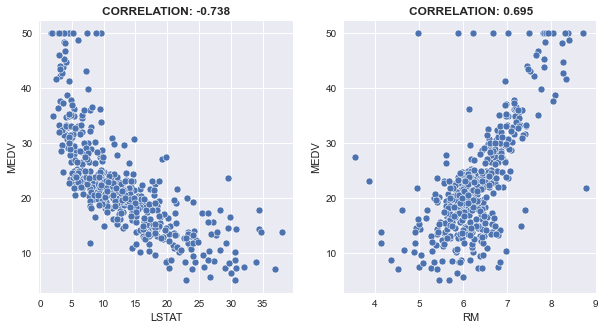

In [13]:
features = ['lstat', 'rm']
fig, axes = plt.subplots(1, len(features), figsize=(10,5))

for ax, col in zip(axes.flat, features):
    sns.scatterplot(x=boston[col], y=boston['medv'], ax=ax)
    ax.set_title(f"CORRELATION: {round(boston.corr().loc['medv', col], 3)}", fontweight='bold')
    ax.set_xlabel(col.upper())
    ax.set_ylabel('MEDV')

2. Hindari multikolinearitas, yaitu hindari menggunakan dua feature sekaligus yang memiliki korelasi kuat. Ketika terjadi multikolinearitas, maka feature yang digunakan pada model sebenarnya redundan. Misalnya `rad` dengan `tax` memiliki korelasi 0.910228.

In [14]:
pairwise_corr[pairwise_corr['feature_2'] != 'medv'].sort_values('abs_correlation', ascending = False)

,feature_1,feature_2,correlation,abs_correlation
63,rad,tax,0.910228,0.910228
35,nox,dis,-0.769230,0.769230
23,indus,nox,0.763651,0.763651
50,age,dis,-0.747881,0.747881
34,nox,age,0.731470,0.731470
...,...,...,...,...
0,crim,zn,-0.200469,0.200469
38,nox,ptratio,0.188933,0.188933
72,ptratio,b,-0.177383,0.177383
20,zn,b,0.175520,0.175520


Kesimpulan untuk tahap modeling:
- Feature `chas`, `lstat`, dan `rm` menjadi kandidat predictor yang baik pada model.
- Feature `rad` dan `tax` sebaiknya tidak digunakan bersamaan sebagai predictor pada model.

# Linear Regression

Kita persiapkan `X` untuk features dan `y` untuk target variable. Kemudian lakukan train-test splitting dengan proporsi 80:20.

In [15]:
X = boston.drop('medv', axis=1)
y = boston['medv']
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (506, 13)
Target: (506,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
print(f"Train features: {X_train.shape}")
print(f"Train target: {y_train.shape}")
print(f"Test features: {X_test.shape}")
print(f"Test target: {y_test.shape}")

Train features: (404, 13)
Train target: (404,)
Test features: (102, 13)
Test target: (102,)


Kita cek standar deviasi dari `y_train` sebagai perbandingan dengan evaluasi RMSE. Apabila ternyata nanti RMSE lebih kecil dibandingkan standar deviasinya, maka dapat dikatakan model cukup baik.

In [17]:
y_train.std()

9.028225819481873

## Baseline Model

Practice yang baik dalam membuat model Machine Learning adalah membuat baseline model. Dalam hal ini, kita memuat model Linear Regression dengan **semua feature** dan **tanpa melakukan scaling**.

In [18]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

LinearRegression()

Buat function `evaluate` untuk agar model yang telah dibuat menggunakan data train dapat dievaluasi menggunakan data test. Evaluasi ditinjau dari:
1. Nilai R-squared: semakin besar maka semakin baik
2. Nilai RMSE: semakin kecil maka semakin baik
3. Scatter plot nilai actual vs prediksi: semakin mendekati garis $y=x$ artinya nilai actual = prediksi, maka semakin baik

Ketiga poin evaluasi tersebut dilakukan pada data train dan juga test dengan tujuan melihat fitting model kita:

| Data Train | Data Test | Fitting      |
|------------|-----------|--------------|
| Baik       | Buruk     | Overfitting  |
| Baik       | Baik      | Just Right   |
| Buruk      | Buruk     | Underfitting |

In [19]:
def evaluate(model, model_name, X_train, y_train, X_test, y_test, plot=True):
    # prediksi
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # simpan nilai R-squared dan RMSE
    metric = \
    {model_name:
     {('R-squared', 'Test'): model.score(X_test, y_test),
      ('R-squared', 'Train'): model.score(X_train, y_train),
      ('RMSE', 'Test'): mean_squared_error(y_test, y_pred_test, squared=False),
      ('RMSE', 'Train'): mean_squared_error(y_train, y_pred_train, squared=False)}}
    
    # visualisasi nilai actual vs prediksi
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        data = [(y_test, y_pred_test), (y_train, y_pred_train)]
        title = ['TEST SET', 'TRAIN SET']

        for ax, (x, y), title in zip(axes, data, title):
            sns.scatterplot(x=x, y=y, ax=ax)
            ax.plot(x, x, color='red', lw=1)
            ax.set_xlabel("ACTUAL MEDV")
            ax.set_ylabel("PREDICTED MEDV")
            ax.set_title(title)

        plt.suptitle(f"MODEL: {model_name.upper()}", fontweight='bold')
        plt.show()
    
    return pd.DataFrame(metric).T

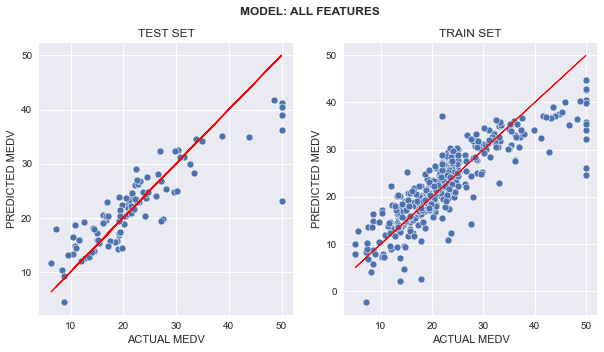

R-squared                RMSE          
                  Test     Train      Test     Train
All Features  0.755503  0.733733  4.859732  4.652889

In [20]:
eval_baseline = evaluate(baseline_model, "All Features",
                         X_train, y_train,
                         X_test, y_test)
eval_baseline

Dari performa `baseline_model` di atas, model dapat dikatakan cukup fit dengan R-squared di data test sebesar 75,55%. Pertanyaannya apakah kita dapat improve performa dari model kita?

## Feature Scaling

Terdapat dua metode scaling:
1. Min Max Scaling: mengubah range menjadi antara 0 sampai 1
2. Standard Scaling: mengubah nilai agar memiliki mean=0 dan sd=1

Pada bagian ini, kita coba implementasi **MinMaxScaler** saja karena idenya sama. Langkah sebagai berikut:

1. Lakukan scaling **hanya pada `X_train`**, hasilnya kita sebut sebagai `X_train_min_max`
2. Fitting model dengan feature `X_train_min_max` dan target `y_train`
3. Evaluasi model, namun lakukan scaling pada `X_test` menggunakan **scaler yang sama** dengan `X_train`

Referensi: https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
min_max_scaler_X = MinMaxScaler()
X_train_min_max = min_max_scaler_X.fit_transform(X_train)

In [23]:
min_max_model = LinearRegression()
min_max_model.fit(X_train_min_max, y_train)

LinearRegression()

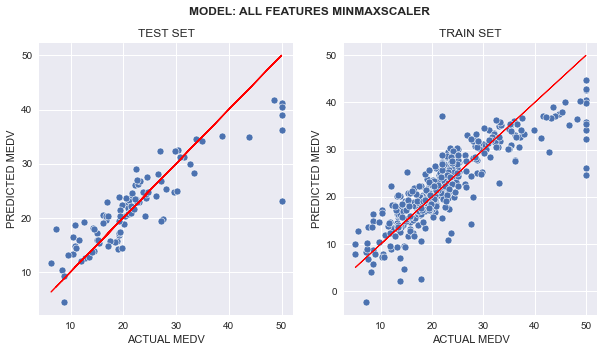

R-squared                RMSE          
                               Test     Train      Test     Train
All Features MinMaxScaler  0.755503  0.733733  4.859732  4.652889

In [24]:
eval_min_max = evaluate(min_max_model, "All Features MinMaxScaler",
                        X_train_min_max, y_train,
                        min_max_scaler_X.transform(X_test), y_test)
eval_min_max

Ternyata, feature scaling pada Multiple Linear Regression tidak berpengaruh terhadap performa model. Mengapa? karena terdapat intercept dan coefficient pada regresi yang menyesuaikan terhadap data, sehingga pada kasus ini sebenarnya tidak diperlukan. Namun apabila secara waktu komputasi, scaling akan berguna karena komputasi angkanya lebih ringan. Referensi: https://stats.stackexchange.com/questions/121886/when-should-i-apply-feature-scaling-for-my-data

Kita dapat membandingkan persamaan regresi linear dari `baseline_model` dan `min_max_model` sebagai berikut:

In [25]:
def print_formula(model, X, y):
    formula = f'{y.name} = {round(model.intercept_, 3)} '
    for coef, feature in zip(model.coef_, X.columns):
        sign = '+' if coef > 0 else '-'
        formula += f'{sign} {round(abs(coef), 3)} * {feature} '
    display(Math(formula))

In [26]:
print_formula(baseline_model, X, y)

<IPython.core.display.Math object>

In [27]:
print_formula(min_max_model, X, y)

<IPython.core.display.Math object>

Dari sini kita tetap memilih `baseline_model` dengan pertimbangan feature yang digunakan masih berupa nilai asli, sehingga formula yang dihasilkan tidak misleading ketika diinterpretasikan.

## Feature Selection

Bagaimana apabila kita menggunakan beberapa feature saja? Terdapat banyak metode untuk melakukan feature selection, namun pada notebook ini saya sajikan dua diantaranya:

### Recursive Feature Elimination

Pada `sklearn` terdapat fungsi `RFE()` yaitu Recursive Feature Elimination yang idenya membuat feature ranking dari yang paling berkontribusi sampai yang paling tidak berkontribusi.

Referensi: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [28]:
from sklearn.feature_selection import RFE

Kita dapat secara iteratif coba untuk memperoleh model yang terbaik ketika menggunakan 1-13 features:

In [29]:
df_list = []
feature_list = []

for n_features in range(1, len(X.columns)+1):
    # feature selection
    selector = RFE(baseline_model, n_features_to_select=n_features)
    selector = selector.fit(X_train, y_train)
    
    X_train_selected = X_train.loc[:,selector.support_]
    X_test_selected = X_test.loc[:,selector.support_]
    
    # modeling
    lr = LinearRegression()
    lr.fit(X_train_selected, y_train)
    
    # evaluation
    eval_df = evaluate(lr, f"RFE {n_features} features",
                       X_train_selected, y_train,
                       X_test_selected, y_test, plot=False)
    
    df_list.append(eval_df)
    feature_list.append(list(X.columns[selector.support_]))

In [30]:
eval_rfe = pd.concat(df_list)
eval_rfe['Features'] = feature_list
eval_rfe

R-squared                RMSE            \
                     Test     Train      Test     Train   
RFE 1 features   0.177278  0.183740  8.914612  8.146642   
RFE 2 features   0.543972  0.531932  6.637000  6.169057   
RFE 3 features   0.556237  0.554558  6.547137  6.018106   
RFE 4 features   0.622522  0.612842  6.038397  5.610587   
RFE 5 features   0.643967  0.629623  5.864362  5.487646   
RFE 6 features   0.730446  0.710056  5.102681  4.855359   
RFE 7 features   0.728710  0.712200  5.119085  4.837376   
RFE 8 features   0.745221  0.714452  4.960870  4.818413   
RFE 9 features   0.746969  0.719172  4.943822  4.778425   
RFE 10 features  0.749706  0.727464  4.917007  4.707347   
RFE 11 features  0.757481  0.733506  4.840035  4.654872   
RFE 12 features  0.755671  0.733729  4.858063  4.652925   
RFE 13 features  0.755503  0.733733  4.859732  4.652889   

                                                          Features  
                                                                    
RFE 1 features                                               [nox]  
RFE 2 features                                           [nox, rm]  
RFE 3 features                                     [chas, nox, rm]  
RFE 4 features                            [chas, nox, rm, ptratio]  
RFE 5 features                       [chas, nox, rm, dis, ptratio]  
RFE 6 features                [chas, nox, rm, dis, ptratio, lstat]  
RFE 7 features           [chas, nox, rm, dis, rad, ptratio, lstat]  
RFE 8 features     [crim, chas, nox, rm, dis, rad, ptratio, lstat]  
RFE 9 features   [crim, zn, chas, nox, rm, dis, rad, ptratio, l...  
RFE 10 features  [crim, zn, chas, nox, rm, dis, rad, tax, ptrat...  
RFE 11 features  [crim, zn, chas, nox, rm, dis, rad, tax, ptrat...  
RFE 12 features  [crim, zn, chas, nox, rm, age, dis, rad, tax, ...  
RFE 13 features  [crim, zn, indus, chas, nox, rm, age, dis, rad...

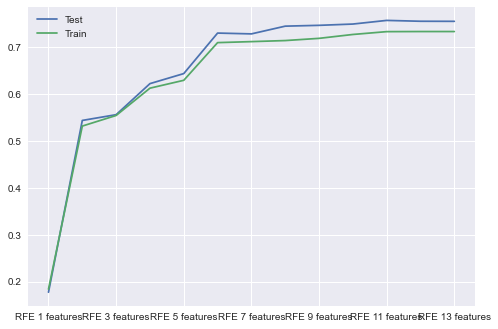

In [31]:
eval_rfe['R-squared'].plot.line()
plt.show()

Berdasarkan tabel dan plot di atas, diperoleh bahwa ketika menggunakan **11 features** dengan `RFE()`, maka menghasilkan performa R-squared di data test paling baik.

In [33]:
rfe_feature = eval_rfe.loc['RFE 11 features', 'Features'].values[0]
X_train_rfe = X_train.loc[:,rfe_feature]
rfe_model = LinearRegression()
rfe_model.fit(X_train_rfe, y_train)

LinearRegression()

In [34]:
print_formula(rfe_model, X_train_rfe, y)

<IPython.core.display.Math object>

Pada `rfe_model`, terdapat 2 prediktor yang tidak digunakan, yaitu `indus` dan `age`.

### Variable Inflation Factor (VIF)

VIF adalah nilai yang digunakan untuk menentukan **derajat multikolinearitas** untuk tiap prediktor. Nilai VIF **di atas 10** dianggap bahwa terjadi multikolinearitas pada data.

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [36]:
def compute_vif(X):
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["Feature"] = X.columns
    return vif

Di sini secara iteratif saya melakukan remove predictor untuk nilai VIF yang paling terbesar.

In [37]:
X_train_vif = X_train.copy()
while True:
    vif = compute_vif(X_train_vif)
    largest_vif = vif.sort_values('VIF', ascending=False).head(1)
    if largest_vif['VIF'].values[0] > 10:
        drop_feature = largest_vif['Feature'].values[0]
        X_train_vif.drop(drop_feature, axis=1, inplace=True)
    else:
        break

Berikut adalah hasil akhir dari feature-feature yang digunakan. Sudah tidak ada lagi nilai VIF yang di atas 10.

In [38]:
compute_vif(X_train_vif)

,VIF,Feature
0,2.330002,crim
1,2.273845,zn
2,7.058626,indus
3,1.090850,chas
4,4.079935,dis
5,4.792627,rad
6,6.910190,lstat


In [39]:
vif_model = LinearRegression()
vif_model.fit(X_train_vif, y_train)

LinearRegression()

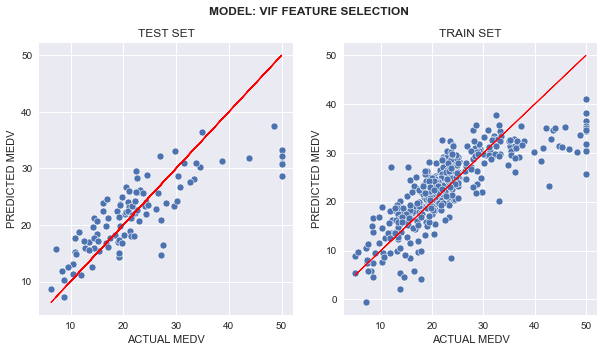

R-squared                RMSE          
                           Test     Train      Test     Train
VIF Feature Selection  0.625064  0.635326  6.018032  5.445237

In [40]:
eval_vif = evaluate(vif_model, "VIF Feature Selection",
                    X_train_vif, y_train,
                    X_test[X_train_vif.columns], y_test)
eval_vif

# Conclusion

Berikut adalah perbandingan performa keempat model yang telah kita buat:

In [41]:
pd.concat([eval_baseline,
           eval_min_max,
           eval_rfe.loc[['RFE 11 features'], ['R-squared', 'RMSE']],
           eval_vif])

R-squared                RMSE          
                               Test     Train      Test     Train
All Features               0.755503  0.733733  4.859732  4.652889
All Features MinMaxScaler  0.755503  0.733733  4.859732  4.652889
RFE 11 features            0.757481  0.733506  4.840035  4.654872
VIF Feature Selection      0.625064  0.635326  6.018032  5.445237

**Trade-off:** Apabila kita menggunakan model RFE 11 features, kita mendapatkan model dengan performa yang terbaik, namun model dikatakan masih bias karena terjadi multikolinearitas pada data. Ketika menggunakan model VIF Feature Selection, model tidak bias karena multikolinearitasnya rendah, namun performa model lebih buruk.

In [42]:
print_formula(baseline_model, X_train, y)

<IPython.core.display.Math object>

In [43]:
print_formula(rfe_model, X_train_rfe, y)

<IPython.core.display.Math object>

In [44]:
print_formula(vif_model, X_train_vif, y)

<IPython.core.display.Math object>

Walaupun performa ketiga model di atas berbeda-beda, namun efek dari masing-masing predictor ke target variable `medv` sama.

Nilai rumah di Boston akan naik apabila nilai-nilai berikut semakin tinggi:
- `zn`: semakin luas tanah tempat tinggal, harga rumah akan lebih mahal
- `chas`: apabila saluran berbatasan dengan Charles River, harga rumah akan lebih mahal
- `rm`: semakin banyak kamar per hunian, harga rumah akan lebih mahal
- `rad`: semakin tinggi aksesibilitas ke jalan raya, harga rumah akan lebih mahal
- `b`: semakin tinggi proporsi orang kulit hitam, harga rumah akan lebih mahal (ini cukup SARA, mungkin pada real case variable ini boleh di takeout)

Nilai rumah di Boston akan turun apabila nilai nilai berikut semakin tinggi:
- `crim`: semakin tinggi tingkat kriminalitas, harga rumah akan lebih murah
- `indus`: semakin banyak bisnis perindustrian, harga rumah akan lebih murah
- `nox`: semakin tinggi konsentrasi nitrogen oksida (polusi), harga rumah akan lebih murah
- `age`: semakin tinggi proporsi unit yang usang, harga rumah akan lebih murah
- `dis`: semakin jauh dengan pusat kerja, harga rumah akan lebih murah
- `tax`: semakin tinggi tarif pajak, harga rumah akan lebih murah
- `ptratio`: semakin tinggi rasio murid dengan guru (kurangnya fasilitas edukasi), harga rumah akan lebih murah
- `lstat`: semakin banyak penduduk marginal, harga rumah akan lebih murah

Performa model terbaik: 75.7481%, namun masih melanggar asumsi dari linear regression. Untuk improve model ini, bisa coba hal-hal berikut:

- Handle outlier dari target variable: Remove outlier ataupun transformasi nilai `medv` dengan fungsi log atau sqrt.
- Gunakan algoritma lain yang lebih robust, misalnya: Random Forest Regression.